In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
new_style = {'grid': False}
plt.rc('axes', **new_style)

import pulse2percept as p2p

2017-04-25 12:59:30,877 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
encoding = 'amplitude'
invert = True
letter = 'O'

datafile = 'letters/%s.jpg' % letter
if invert:
    file = '%s-%s-sampling50-invert-old' % (letter, encoding)
else:
    file = '%s-%s-sampling50-old' % (letter, encoding)
stimfile = 'stim-%s.dat' % file
perceptfile = 'percept-%s.jpg' % file

In [3]:
# Place an Argus I array on the retina
argus = p2p.implants.ArgusII(x_center=0, y_center=0, h=0, rot=0*np.pi/180)

In [4]:
sim = p2p.Simulation(argus, engine='joblib', num_jobs=10)

In [5]:
# Set parameters of the optic fiber layer (OFL)
# In previous versions of the model, this used to be called the `Retina`
# object, which created a spatial grid and generated the axtron streak map.
sampling = 150       # spatial sampling of the retina (microns)
axon_lambda = 1        # constant that determines fall-off with axonal distance
sim.set_optic_fiber_layer(sampling=sampling, axon_lambda=axon_lambda,
                          x_range=[-4000, 4000], y_range=[-3000, 3000])

In [6]:
# Set parameters of the ganglion cell layer (GCL)
# In previous versions of the model, this used to be called `TemporalModel`.
t_gcl = 5e-6   # Sampling step (s) for the GCL computation
sim.set_ganglion_cell_layer(tsample=t_gcl)

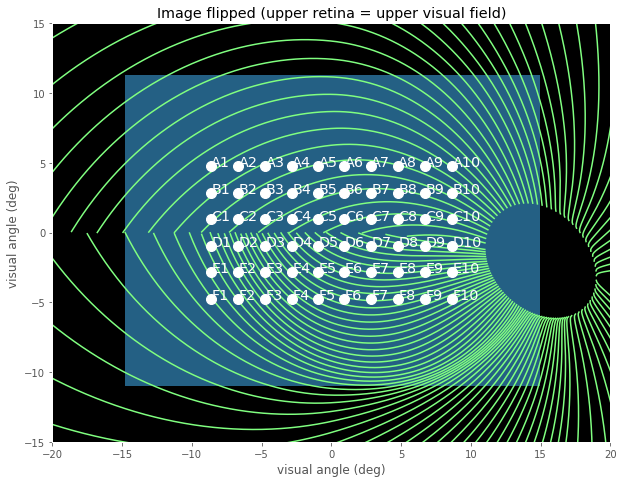

In [7]:
sim.plot_fundus()
plt.savefig('fundus.jpg')

In [8]:
import skimage.io as sio
import skimage.transform as sit

In [9]:
img_in = sio.imread(datafile, as_gray=True)
img_in = img_in[50:150, 70:190]
img_in.shape

(100, 120)

In [10]:
img_stim = sit.resize(img_in, (6, 10))
if invert:
    img_stim = 1.0 -img_stim
img_stim.shape, img_stim.dtype

((6, 10), dtype('float64'))

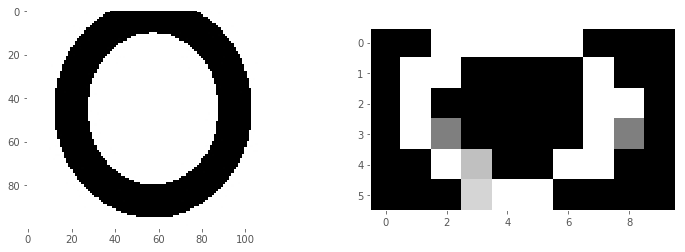

In [11]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.imshow(img_in, cmap='gray')
plt.subplot(122)
plt.imshow(img_stim, cmap='gray')

In [12]:
stim = {}
idx = 0
for row in img_stim:
    for px in row:
#         if idx % 2 == 0:
#             idx += 1
#             continue
        name = argus[idx].name
        if encoding == 'frequency':
            stim[name] = p2p.stimuli.PulseTrain(t_gcl, freq=px * 50.0, amp=20, dur=0.5,
                                                pulse_dur=0.45 / 1000,
                                                interphase_dur=0.45 / 1000,
                                                delay=0)
        elif encoding == 'amplitude':
            stim[name] = p2p.stimuli.PulseTrain(t_gcl, amp=px * 60.0, freq=20, dur=0.5,
                                                pulse_dur=0.45 / 1000,
                                                interphase_dur=0.45 / 1000,
                                                delay=0)
        else:
            raise ValueError('Unknown encoding mode ' + encoding)
        idx += 1

In [13]:
percept = sim.pulse2percept(stim, tol=0.25, layers=['GCL', 'OFL'])

2017-04-25 12:59:33,057 [pulse2percept.api] [INFO] Starting pulse2percept...


AttributeError: module 'pulse2percept.retina' has no attribute 'SUPPORTED_LAYERS'

In [ ]:
frame = p2p.get_brightest_frame(percept)

In [ ]:
img = np.flipud(percept.data[..., int(0.5 / percept.tsample)])
plt.figure(figsize=(8, 5))
plt.imshow(np.flipud(img), cmap='gray', vmin=0)
plt.grid('off')
plt.colorbar()